In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Usual library
import numpy   as np
import pandas  as pd

# Dataset exploration functions
import dataset as d

Welcome to ROOTaaS 6.06/08


In [2]:
data = d.get_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Columns: 327 entries, mc_generator_weights to electronCollection
dtypes: bool(5), float32(73), int32(47), int8(16), object(180), uint32(5), uint64(1)
memory usage: 38.2+ MB


In [3]:
data_collection = data[['jetCollection','muonCollection','electronCollection']]
data_collection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 3 columns):
jetCollection         20343 non-null object
muonCollection        20343 non-null object
electronCollection    20343 non-null object
dtypes: object(3)
memory usage: 476.9+ KB


In [51]:
%timeit -n 1 data.apply(d.compute_manydR, axis=1)

1 loop, best of 3: 8.66 s per loop


In [52]:
%timeit -n 1 data_collection.apply(d.compute_manydR, axis=1)

1 loop, best of 3: 7.88 s per loop


In [7]:
# Parallelization with ipyparallel
import ipyparallel

cluster = ipyparallel.Client(profile='default')
dview = cluster[:]

print( 'profile:     ', cluster.profile)
print( 'IDs:         ', cluster.ids    ) # Print process id numbers
print( 'direct views ', dview)

('profile:     ', u'default')
('IDs:         ', [0, 1, 2, 3])
('direct views ', <DirectView [0, 1, 2, 3]>)


In [8]:
def parallelized_function(small_df):
    return small_df.apply(d.compute_manydR, axis=1)

In [55]:
array_small_df = np.array_split(data, 200)
for df in array_small_df[0:10]:
    %timeit -n 1 df.apply(d.compute_manydR, axis=1)

1 loop, best of 3: 39.3 ms per loop
1 loop, best of 3: 40.2 ms per loop
1 loop, best of 3: 42 ms per loop
1 loop, best of 3: 42.4 ms per loop
1 loop, best of 3: 40.3 ms per loop
1 loop, best of 3: 40.4 ms per loop
1 loop, best of 3: 45.9 ms per loop
1 loop, best of 3: 42.5 ms per loop
1 loop, best of 3: 38.6 ms per loop
1 loop, best of 3: 40 ms per loop


In [56]:
array_small_df_collection = np.array_split(data_collection, 200)
for df in array_small_df_collection[0:10]:
    %timeit -n 1 df.apply(d.compute_manydR, axis=1)

1 loop, best of 3: 37.2 ms per loop
1 loop, best of 3: 42.3 ms per loop
1 loop, best of 3: 47 ms per loop
1 loop, best of 3: 48 ms per loop
1 loop, best of 3: 38.5 ms per loop
1 loop, best of 3: 44.5 ms per loop
1 loop, best of 3: 48.2 ms per loop
1 loop, best of 3: 46.5 ms per loop
1 loop, best of 3: 45.8 ms per loop
1 loop, best of 3: 48.3 ms per loop


In [57]:
%timeit -n 1 dview.map(parallelized_function, array_small_df)

1 loop, best of 3: 21.1 s per loop


In [58]:
%timeit -n 1 dview.map(parallelized_function, array_small_df_collection)

1 loop, best of 3: 3.77 s per loop


In [5]:
#timing
from timeit import default_timer

import matplotlib        as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5

In [16]:
Nsplit=[1,10,100,200,500,1000]
dt=[]
for n in Nsplit:
    mydata = np.array_split(data_collection,n)
    t0 = default_timer()
    %timeit -n 1 dview.map(parallelized_function, mydata)
    t1 = default_timer()
    dt.append((t1-t0)/3.)

1 loop, best of 3: 3.23 s per loop
1 loop, best of 3: 3.45 s per loop
1 loop, best of 3: 3.41 s per loop
1 loop, best of 3: 3.48 s per loop
1 loop, best of 3: 3.54 s per loop
1 loop, best of 3: 3.54 s per loop


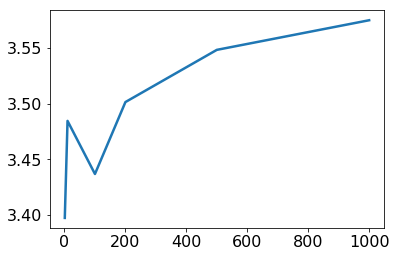

In [17]:
plt.plot(Nsplit,dt)

In [15]:
%timeit -n 1 data_collection.apply(d.compute_manydR, axis=1)

1 loop, best of 3: 8.07 s per loop


1 loop, best of 3: 19.3 s per loop
1 loop, best of 3: 21.9 s per loop
1 loop, best of 3: 21.1 s per loop
1 loop, best of 3: 21.3 s per loop
1 loop, best of 3: 20.8 s per loop
1 loop, best of 3: 21.5 s per loop


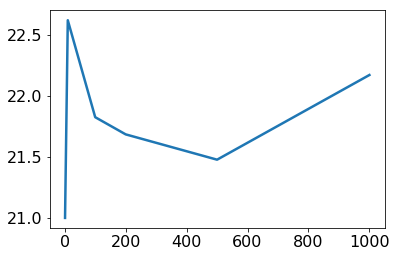

In [18]:
Nsplit=[1,10,100,200,500,1000]
dt=[]
for n in Nsplit:
    mydata = np.array_split(data,n)
    t0 = default_timer()
    %timeit -n 1 dview.map(parallelized_function, mydata)
    t1 = default_timer()
    dt.append((t1-t0)/3.)

plt.plot(Nsplit,dt)

conclusion: this operation seems to be I/O (or memory?) limited ...